# Image classification using the MNIST dataset and Neural Network Analysis

#### The MNIST dataset consists of a series of 70000 greyscale images of handwritten numerals from 0 to 9 and their corresponding label, identifying what number is it. It is a dataset very commonly used for classification analyses and we'll be using a neural network to analyse this dataset.

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

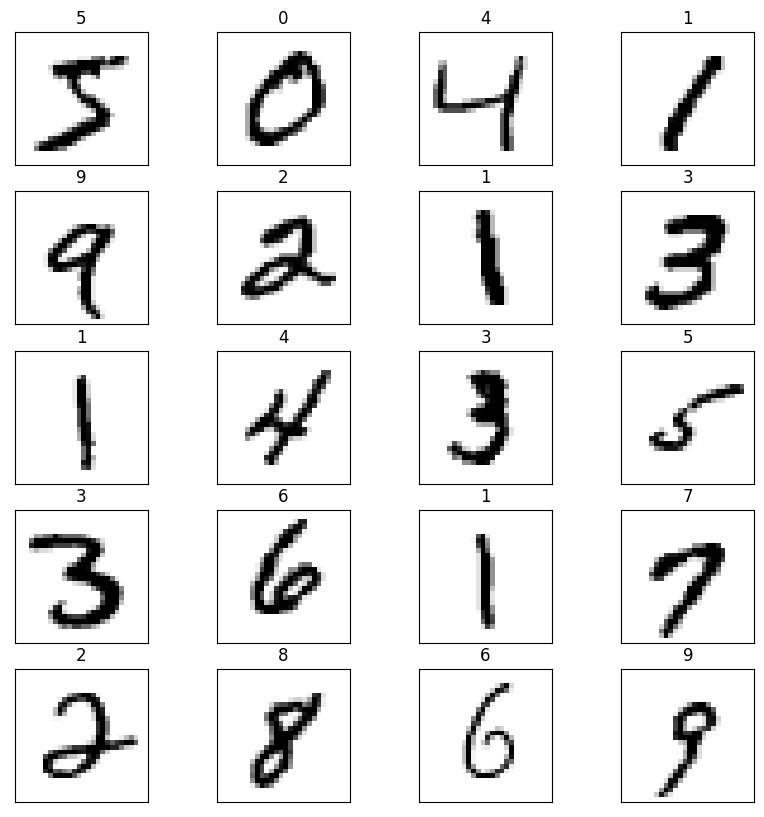

In [27]:
figure = plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5, 4, i + 1, title=train_labels[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.binary)

In [28]:
print("Unique labels =", tf.unique(train_labels))

Unique labels = Unique(y=<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8], dtype=uint8)>, idx=<tf.Tensor: shape=(60000,), dtype=int32, numpy=array([0, 1, 2, ..., 0, 7, 9], dtype=int32)>)


#### We have 10 unique catgories in our data labels, which correspond to the ten digits from 0 to 9 that are included in the handwriting sample. The MNIST dataset is designed to have 60000 training images and 10000 test images, but we can confirm this below.

In [29]:
num_train = 0
for element in train_images:
    num_train += 1
print("Training images: ", num_train)

num_test = 0
for element in test_images:
    num_test += 1
print("Testing images: ", num_test)

Training images:  60000
Testing images:  10000


In [30]:
print('Train - min:', train_images.min(), 'max:', train_images.max())
print('Test - min:', test_images.min(), 'max:', test_images.max())

Train - min: 0 max: 255
Test - min: 0 max: 255


#### The images have a variation in value from 0 to 255, which could cause problems with the analysis. In order to account for this, we will need to create a basic input pipeline that standardises the images to a range between 0 and 1. We also need to convert our labels into categorical values so they will be correct identified as labels, not integer values.

In [31]:
from tensorflow.keras.utils import to_categorical

def normalise_images(data):
  for image in data:
    return tf.cast(image, tf.float32) / 255.

train_ds = normalise_images(train_images)
test_ds = normalise_images(test_images)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

#### Based on our work above, we know that there are 10 categories that we need to solve for in our neural network, and our starting data size is an image of 28 x 28 pixels. Therefore, our input layer is going to be 28 x 28, but our output layer will be 10. We need to include enough layers in our model to step down progressively from 784 to 10.

In [33]:
with tf.device('/device:GPU:0'):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#from tensorflow.keras.utils import plot_model
#plot_model(model, show_shapes=True)

#### Model configuration step - input step needs to be flattened to reduce the number of dimensions. Then we can use dense layers to gradually reduce this down to the final output shape of the 10 categories. I have included two hidden layers in order to facilitate this transition using the more robust 'relu' activation function before using 'softmax' for the output layer as it needs to predict a multinomial probability distribution, which is what we have here.

In [34]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               100480    
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Clear previous logs so can record for TensorBoard
!rm -rf ./logs/ 

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

with tf.device('/device:GPU:0'):
  history = model.fit(x=train_images, y=train_labels,
                      batch_size=64, 
                      epochs=250,
                      validation_split=0.1,
                      callbacks=[tensorboard_callback])

Epoch 1/250
844/844 [==============================] - 9s 8ms/step - loss: 2.5233 - accuracy: 0.8568 - val_loss: 0.5472 - val_accuracy: 0.8917
Epoch 2/250
844/844 [==============================] - 7s 9ms/step - loss: 0.4125 - accuracy: 0.9153 - val_loss: 0.2458 - val_accuracy: 0.9388
Epoch 3/250
844/844 [==============================] - 7s 9ms/step - loss: 0.2976 - accuracy: 0.9339 - val_loss: 0.2309 - val_accuracy: 0.9503
Epoch 4/250
844/844 [==============================] - 6s 7ms/step - loss: 0.2444 - accuracy: 0.9458 - val_loss: 0.2048 - val_accuracy: 0.9610
Epoch 5/250
844/844 [==============================] - 5s 6ms/step - loss: 0.2137 - accuracy: 0.9529 - val_loss: 0.2065 - val_accuracy: 0.9577
Epoch 6/250
844/844 [==============================] - 5s 6ms/step - loss: 0.1938 - accuracy: 0.9589 - val_loss: 0.1989 - val_accuracy: 0.9585
Epoch 7/250
844/844 [==============================] - 6s 7ms/step - loss: 0.1903 - accuracy: 0.9626 - val_loss: 0.2065 - val_accuracy: 0.9623

#### As we're going to be using loss and accuracy graphs a bit in this analysis, I created a function to produce this plots easily.

In [46]:
def loss_graph():
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    return plt.show()

def acc_graph():
    plt.plot(epochs, acc, 'ro', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    return plt.show()


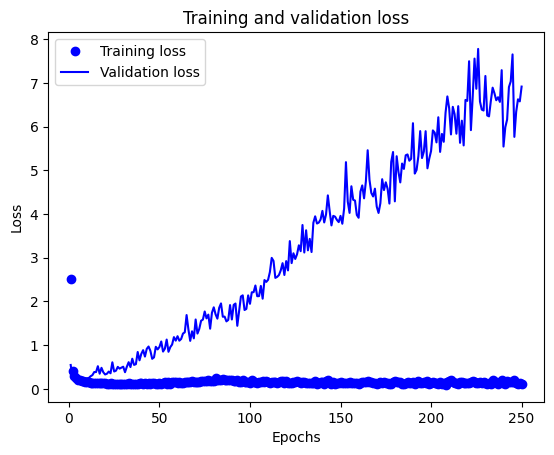

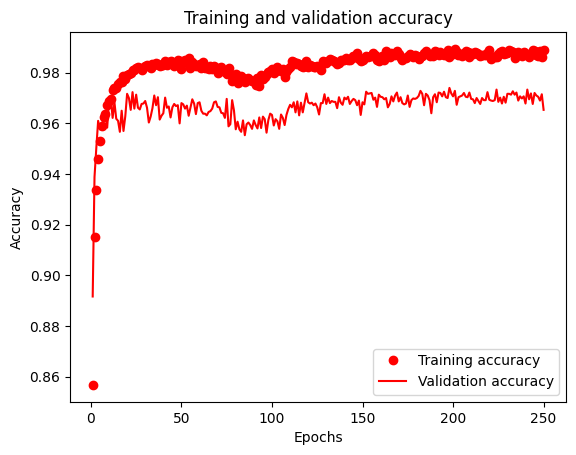

In [36]:
loss_graph()
acc_graph()

#### This initial model appears to have evidence of overfitting, with our training accuracy being much higher than that for the validation. It is quite likely that we don't need as many epochs as we have been running, so I will repeat the experiment with only 50 epochs to compare.

In [38]:
# Clear previous logs so can record for TensorBoard
!rm -rf ./logs/ 

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

with tf.device('/device:GPU:0'):
  history = model.fit(x=train_images, y=train_labels,
                      batch_size=64, 
                      epochs=50,
                      validation_split=0.1,
                      callbacks=[tensorboard_callback]
                      )

Epoch 1/50
844/844 [==============================] - 8s 9ms/step - loss: 0.1491 - accuracy: 0.9871 - val_loss: 6.9541 - val_accuracy: 0.9733
Epoch 2/50
844/844 [==============================] - 8s 10ms/step - loss: 0.1367 - accuracy: 0.9891 - val_loss: 7.1127 - val_accuracy: 0.9710
Epoch 3/50
844/844 [==============================] - 7s 9ms/step - loss: 0.1032 - accuracy: 0.9885 - val_loss: 7.6035 - val_accuracy: 0.9718
Epoch 4/50
844/844 [==============================] - 7s 9ms/step - loss: 0.1123 - accuracy: 0.9892 - val_loss: 7.1534 - val_accuracy: 0.9708
Epoch 5/50
844/844 [==============================] - 5s 6ms/step - loss: 0.0886 - accuracy: 0.9890 - val_loss: 6.7318 - val_accuracy: 0.9733
Epoch 6/50
844/844 [==============================] - 5s 6ms/step - loss: 0.1971 - accuracy: 0.9893 - val_loss: 8.6174 - val_accuracy: 0.9695
Epoch 7/50
844/844 [==============================] - 7s 8ms/step - loss: 0.1673 - accuracy: 0.9870 - val_loss: 6.1995 - val_accuracy: 0.9717
Epoch

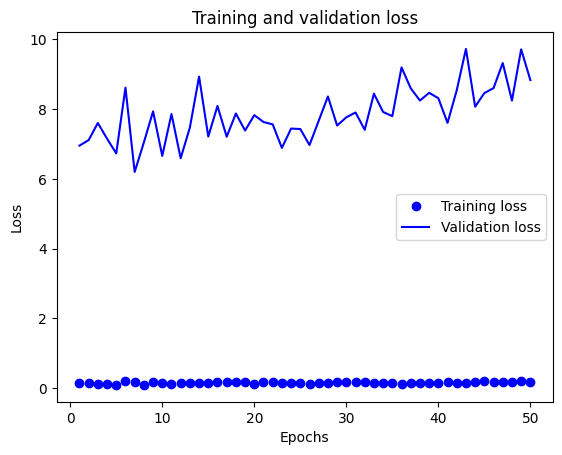

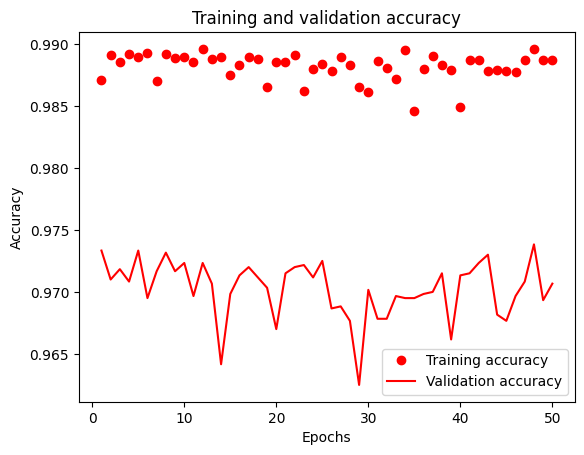

In [39]:
loss_graph()
acc_graph()

#### Reducing the number of epochs does improve the overfitting situation, but now the loss is substantially different between the training and validation. Another option is to reduce the learning rate, which may be necessary considering that we now have fewer epochs.

In [41]:
from tensorflow.keras import optimizers

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(10,activation='softmax')])

model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

with tf.device('/device:GPU:0'):
  history = model.fit(x=train_images, y=train_labels,
                      batch_size=64, 
                      epochs=50,
                      validation_split=0.1)

/Users/home/repos/kamitc/mnist_venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
844/844 [==============================] - 9s 8ms/step - loss: 8.6047 - accuracy: 0.7437 - val_loss: 2.0380 - val_accuracy: 0.8843
Epoch 2/50
844/844 [==============================] - 6s 7ms/step - loss: 1.7790 - accuracy: 0.8854 - val_loss: 1.2634 - val_accuracy: 0.9062
Epoch 3/50
844/844 [==============================] - 6s 7ms/step - loss: 1.1143 - accuracy: 0.9144 - val_loss: 1.0140 - val_accuracy: 0.9190
Epoch 4/50
844/844 [==============================] - 5s 6ms/step - loss: 0.7781 - accuracy: 0.9294 - val_loss: 0.8561 - val_accuracy: 0.9272
Epoch 5/50
844/844 [==============================] - 6s 7ms/step - loss: 0.5928 - accuracy: 0.9405 - val_loss: 0.7432 - val_accuracy: 0.9342
Epoch 6/50
844/844 [==============================] - 6s 7ms/step - loss: 0.4515 - accuracy: 0.9497 - val_loss: 0.7031 - val_accuracy: 0.9383
Epoch 7/50
844/844 [==============================] - 6s 7ms/step - loss: 0.3580 - accuracy: 0.9569 - val_loss: 0.6305 - val_accuracy: 0.9433
Epoch 

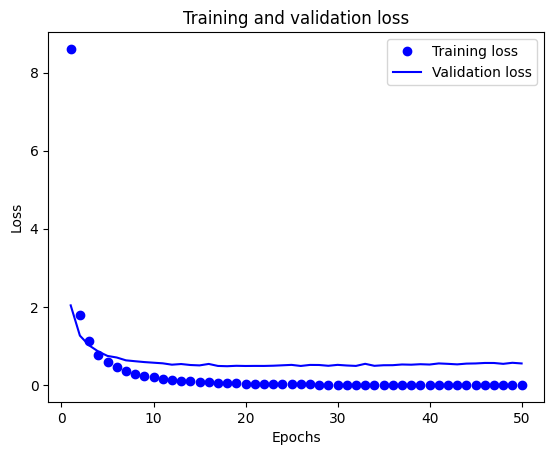

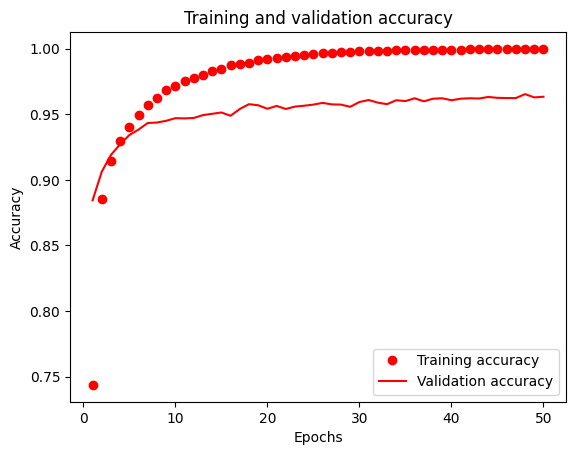

In [42]:
loss_graph()
acc_graph()

#### The validation loss is substantially improved but the overfitting issue is not as good for the accuracy with this model. We can also look at adding batch normalization to the process to try to counter that variation. 

In [43]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(64,activation='relu'),
  BatchNormalization(
        momentum=0.95, 
        epsilon=0.005),
  tf.keras.layers.Dense(10,activation='softmax')])

model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

with tf.device('/device:GPU:0'):
  history = model.fit(x=train_images, y=train_labels,
                      batch_size=64, 
                      epochs=50,
                      validation_split=0.1)

Epoch 1/50
844/844 [==============================] - 9s 8ms/step - loss: 0.5979 - accuracy: 0.8255 - val_loss: 0.2276 - val_accuracy: 0.9432
Epoch 2/50
844/844 [==============================] - 5s 6ms/step - loss: 0.2402 - accuracy: 0.9332 - val_loss: 0.1622 - val_accuracy: 0.9585
Epoch 3/50
844/844 [==============================] - 6s 7ms/step - loss: 0.1771 - accuracy: 0.9509 - val_loss: 0.1395 - val_accuracy: 0.9657
Epoch 4/50
844/844 [==============================] - 6s 7ms/step - loss: 0.1415 - accuracy: 0.9605 - val_loss: 0.1131 - val_accuracy: 0.9705
Epoch 5/50
844/844 [==============================] - 6s 7ms/step - loss: 0.1180 - accuracy: 0.9667 - val_loss: 0.1060 - val_accuracy: 0.9707
Epoch 6/50
844/844 [==============================] - 5s 6ms/step - loss: 0.1001 - accuracy: 0.9721 - val_loss: 0.0968 - val_accuracy: 0.9722
Epoch 7/50
844/844 [==============================] - 6s 7ms/step - loss: 0.0865 - accuracy: 0.9759 - val_loss: 0.0919 - val_accuracy: 0.9737
Epoch 

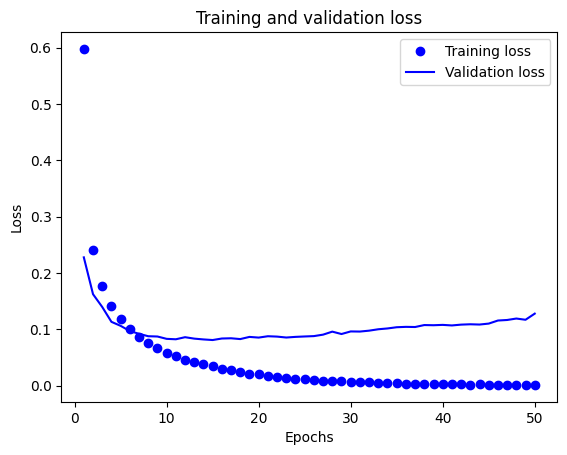

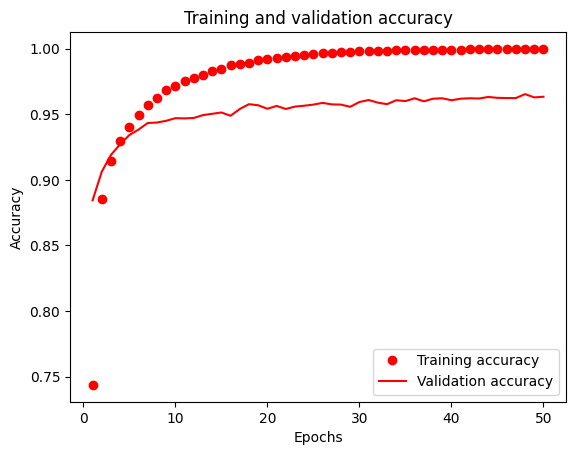

In [47]:
loss_graph()
acc_graph()